**We are using Sartaj + FigShare for train, val and test split**

**Test it on two more datasets**

**TensorFlow 2.9.1 will be used because it can save the model other higher versions give error**

**Importing Modules**

In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting unin

In [ ]:
# !pip install tensorflow==2.9.1
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
# import shutil
import time
import cv2 as cv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import copy as cp

2.9.1


**Connecting with Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Mounting to Dataset Folder**

In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%ls /content/drive/MyDrive/FYP

 Datasets/  'Saved Results'/  'Testing Datasets'/


In [ ]:
%ls /content/drive/MyDrive/FYP/Datasets

1_FigShare/  2_Sartaj/  Segmentation_Figshare/


**Image Processing Techniques**

**Cropping Images**

In [ ]:
def crop_image(img, GAP_VAL = 20):
    try:
      imgW, imgH, imgC = img.shape
    except:
      imgW, imgH = img.shape
      
    image = cp.deepcopy(img)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    ret, image = cv.threshold(image, 20, 255, 0)

    contours, hierarchy = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    max_score = cv.contourArea(contours[0])
    max_score_index = 0
    for i in range(1, len(contours)):
        if cv.contourArea(contours[i]) > max_score:
            max_score = cv.contourArea(contours[i])
            max_score_index = i

    c = contours[max_score_index]
    extLeft = (c[c[:, :, 0].argmin()][0])
    extRight = (c[c[:, :, 0].argmax()][0])
    extTop = (c[c[:, :, 1].argmin()][0])
    extBot = (c[c[:, :, 1].argmax()][0])

    extLeft[0] = extLeft[0] - GAP_VAL
    if extLeft[0] < 0:
        extLeft[0] = 1

    extTop[1] = extTop[1] - GAP_VAL
    if extTop[1] < 0:
        extTop[1] = 1

    extRight[0] = extRight[0] + GAP_VAL
    if extRight[0] > imgW:
        extRight[0] = imgW - 1

    extBot[1] = extBot[1] + GAP_VAL
    if extBot[1] > imgH:
        extBot[1] = imgH - 1

    new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return new_img

**Function for Loading Images From Given Path**

In [ ]:
def load_images(image_size, datasets_path):
  IMAGES = []
  IMAGES_LABELS = []

  ''' Loading Images of Classes '''
  for path in datasets_path:
    for subDirectory in os.listdir(path):
      for image in os.listdir(path + "/" + subDirectory):
        img = cv.imread(path + "/" + subDirectory + "/" + image)
        img = crop_image(img, GAP_VAL=5)  # Cropping
        img = cv.resize(img, image_size)  # Resizing

        # Fliping and Rotation 

        # Adding Original Image to list
        IMAGES.append(img)
        IMAGES_LABELS.append(subDirectory)

        # Adding Horizontal Flipped Image to list
        horizontal_flip = cv.flip(img, 1)
        IMAGES.append(horizontal_flip)
        IMAGES_LABELS.append(subDirectory)

        # Adding Vertical Flipped Image to list
        vertical_flip = cv.flip(img, 0)
        IMAGES.append(vertical_flip)
        IMAGES_LABELS.append(subDirectory)

        # Adding Anti-Clockwise 90 Deg Rotated Image to list
        rotated_anti_90 = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
        IMAGES.append(rotated_anti_90)
        IMAGES_LABELS.append(subDirectory)

        # Adding Clockwise 90 Deg Rotated Image to list
        rotated_clock_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
        IMAGES.append(rotated_clock_90)
        IMAGES_LABELS.append(subDirectory)

  return np.array(IMAGES), np.array(IMAGES_LABELS)

**Images Size**

In [ ]:
images_size = (128, 128, 3)

**Dataset Paths**

In [ ]:
PATHS = [
    "/content/drive/MyDrive/FYP/Datasets/1_FigShare/images",
    "/content/drive/MyDrive/FYP/Datasets/2_Sartaj/Testing",
    "/content/drive/MyDrive/FYP/Datasets/2_Sartaj/Training"
]

**Loading Images**

In [ ]:
images, labels = load_images(images_size[0:2], PATHS)

In [ ]:
print(images.shape)

(31640, 128, 128, 3)


**Show Image**

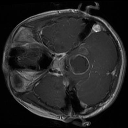

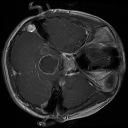

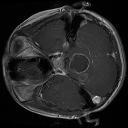

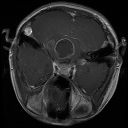

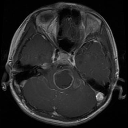

In [ ]:
from google.colab.patches import cv2_imshow
def show_image(img):
  cv2_imshow(img)

show_image(images[0])
show_image(images[1])
show_image(images[2])
show_image(images[3])
show_image(images[4])

**Shuffling Images and Labels**

In [ ]:
Images, Labels = shuffle(images, labels, random_state=101)

In [ ]:
Images.shape

(31640, 128, 128, 3)

**Spliting Images for Testing Dataset**

In [ ]:
rem_images, test_images, rem_labels, test_labels = train_test_split(Images, Labels, test_size = 0.15, random_state = 101)

In [ ]:
print(rem_images.shape)
print(test_images.shape)

(26894, 128, 128, 3)
(4746, 128, 128, 3)


**Spliting Images for Validation and Training**

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(rem_images, rem_labels, test_size = 0.15, random_state = 101)

In [ ]:
print(train_images.shape)
print(val_images.shape)

(22859, 128, 128, 3)
(4035, 128, 128, 3)


**Converting Labels**

In [ ]:
print(train_labels)
print(val_labels)
print(test_labels)

['meningioma' 'glioma' 'meningioma' ... 'glioma' 'pituitary' 'pituitary']
['pituitary' 'meningioma' 'glioma' ... 'meningioma' 'meningioma'
 'meningioma']
['no_tumor' 'meningioma' 'glioma' ... 'no_tumor' 'pituitary' 'glioma']


In [ ]:
CLASSES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

In [ ]:
temp_train = []
for i in train_labels:
    temp_train.append(CLASSES.index(i))
train_labels = temp_train
train_labels = tf.keras.utils.to_categorical(train_labels)

temp_val = []
for i in val_labels:
    temp_val.append(CLASSES.index(i))
val_labels = temp_val
val_labels = tf.keras.utils.to_categorical(val_labels)

temp_test = []
for i in test_labels:
    temp_test.append(CLASSES.index(i))
test_labels = temp_test
test_labels = tf.keras.utils.to_categorical(test_labels)


In [ ]:
print(train_labels)
print(val_labels)
print(test_labels)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


**Mounting to folder where models' .h5 file going to store**

In [ ]:
%cd /content/drive/MyDrive/FYP/Saved\ Results/

/content/drive/MyDrive/FYP/Saved Results


# Retraining Models

In [ ]:
retrain_epochs = 10

In [ ]:
%ls

ContrastImage_EfficientNetB4_20.h5        EfficientNetB4_training_20_epochs/
DenseNet121_20_10.h5                      InceptionV3_20.h5
DenseNet121_20_10_retraining__epochs/     InceptionV3_training_20_epochs/
DenseNet121_20.h5                         MobileNetV2_20.h5
DenseNet121_training_20_epochs/           MobileNetV2_training_20_epochs/
EfficientNetB4_20_10.h5                   ResNet50_20_10.h5
EfficientNetB4_20_10_retraining__epochs/  ResNet50_20_10_retraining__epochs/
EfficientNetB4_20.h5                      ResNet50_20.h5
EfficientNetB4_20_retraining_10_epochs/   ResNet50_training_20_epochs/


**DenseNet121**

In [ ]:
model_path = "DenseNet121_20.h5"
model_name = "DenseNet121_20"
r_model = load_model(model_path)
checkpoint_path = model_name + "_" + str(retrain_epochs) + "_retraining_" + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = r_model.fit(train_images, train_labels, epochs=retrain_epochs, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])
r_model.save(model_name + "_" + str(retrain_epochs) + ".h5")

test_loss, test_accuracy = r_model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)
pred = r_model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)
print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)
print(cm.diagonal()/cm.sum(axis=1))


Epoch 1/10
715/715 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.9973
Epoch 1: saving model to DenseNet121_20_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 107s 139ms/step - loss: 0.0558 - accuracy: 0.9973 - val_loss: 0.0754 - val_accuracy: 0.9903
Epoch 2/10
715/715 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9972
Epoch 2: saving model to DenseNet121_20_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 97s 135ms/step - loss: 0.0543 - accuracy: 0.9972 - val_loss: 0.0747 - val_accuracy: 0.9923
Epoch 3/10
715/715 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9975
Epoch 3: saving model to DenseNet121_20_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 96s 135ms/step - loss: 0.0517 - accuracy: 0.9975 - val_loss: 0.0659 - val_accuracy: 0.9926
Epoch 4/10
715/715 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9976
Epo

**EfficientNetB4**

In [ ]:
model_path = "EfficientNetB4_20_10.h5"
model_name = "EfficientNetB4_20_10"
r_model = load_model(model_path)
checkpoint_path = model_name + "_" + str(retrain_epochs) + "_retraining_" + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = r_model.fit(train_images, train_labels, epochs=retrain_epochs, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])
r_model.save(model_name + "_" + str(retrain_epochs) + ".h5")

test_loss, test_accuracy = r_model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)
pred = r_model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)
print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)
print(cm.diagonal()/cm.sum(axis=1))


Epoch 1/10
715/715 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9989
Epoch 1: saving model to EfficientNetB4_20_10_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 222s 275ms/step - loss: 0.0434 - accuracy: 0.9989 - val_loss: 0.0483 - val_accuracy: 0.9968
Epoch 2/10
715/715 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9978
Epoch 2: saving model to EfficientNetB4_20_10_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 194s 271ms/step - loss: 0.0471 - accuracy: 0.9978 - val_loss: 0.0596 - val_accuracy: 0.9913
Epoch 3/10
715/715 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9983
Epoch 3: saving model to EfficientNetB4_20_10_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 197s 276ms/step - loss: 0.0444 - accuracy: 0.9983 - val_loss: 0.0432 - val_accuracy: 0.9973
Epoch 4/10
715/715 [==============================] - ETA: 0s - loss: 0.0417 - 

**ResNet-50**

In [ ]:
model_path = "ResNet50_20.h5"
model_name = "ResNet50_20"
r_model = load_model(model_path)
checkpoint_path = model_name + "_" + str(retrain_epochs) + "_retraining_" + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = r_model.fit(train_images, train_labels, epochs=retrain_epochs, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])
r_model.save(model_name + "_" + str(retrain_epochs) + ".h5")

test_loss, test_accuracy = r_model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)
pred = r_model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)
print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)
print(cm.diagonal()/cm.sum(axis=1))


Epoch 1/10
715/715 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9956
Epoch 1: saving model to ResNet50_20_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 109s 133ms/step - loss: 0.0753 - accuracy: 0.9956 - val_loss: 0.1422 - val_accuracy: 0.9752
Epoch 2/10
715/715 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9965
Epoch 2: saving model to ResNet50_20_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 95s 133ms/step - loss: 0.0721 - accuracy: 0.9965 - val_loss: 0.0774 - val_accuracy: 0.9913
Epoch 3/10
715/715 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9977
Epoch 3: saving model to ResNet50_20_10_retraining__epochs/cp.ckpt
715/715 [==============================] - 95s 133ms/step - loss: 0.0638 - accuracy: 0.9977 - val_loss: 0.1157 - val_accuracy: 0.9804
Epoch 4/10
715/715 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9967
Epoch 4: sav

**Training Code**

In [ ]:
epoch_number = 20

# EfficientNetB4

In [ ]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=images_size, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
checkpoint_path = model_name + "_training_" + str(epoch_number) + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(train_images, train_labels, epochs=epoch_number, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])

Epoch 1/20
715/715 [==============================] - ETA: 0s - loss: 4.1005 - accuracy: 0.8804
Epoch 1: saving model to EfficientNetB4_training_20_epochs/cp.ckpt
715/715 [==============================] - 231s 270ms/step - loss: 4.1005 - accuracy: 0.8804 - val_loss: 1.5043 - val_accuracy: 0.9779
Epoch 2/20
715/715 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.9712
Epoch 2: saving model to EfficientNetB4_training_20_epochs/cp.ckpt
715/715 [==============================] - 190s 266ms/step - loss: 0.7907 - accuracy: 0.9712 - val_loss: 0.3177 - val_accuracy: 0.9913
Epoch 3/20
715/715 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.9829
Epoch 3: saving model to EfficientNetB4_training_20_epochs/cp.ckpt
715/715 [==============================] - 191s 267ms/step - loss: 0.2676 - accuracy: 0.9829 - val_loss: 0.1744 - val_accuracy: 0.9916
Epoch 4/20
715/715 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9885
Epoch 4: s

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

149/149 - 9s - loss: 0.0530 - accuracy: 0.9977 - 9s/epoch - 59ms/step


In [ ]:
print(test_loss, test_accuracy)

0.05302863568067551 0.9976822733879089


In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)

149/149 [==============================] - 12s 53ms/step


In [ ]:
print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
cm

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1725
           1       1.00      0.99      1.00      1214
           2       0.99      1.00      1.00      1428
           3       0.99      1.00      1.00       379

    accuracy                           1.00      4746
   macro avg       1.00      1.00      1.00      4746
weighted avg       1.00      1.00      1.00      4746



array([[1723,    0,    0,    2],
       [   0, 1206,    8,    0],
       [   0,    1, 1427,    0],
       [   0,    0,    0,  379]])

In [ ]:
cm.diagonal()/cm.sum(axis=1)

array([0.99884058, 0.99341021, 0.99929972, 1.        ])

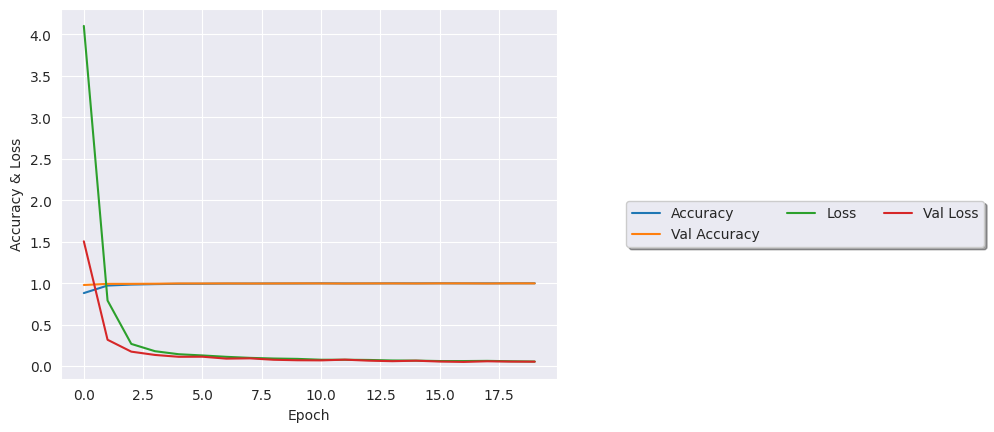

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.5,0.5),
          ncol=3, fancybox=True, shadow=True)

In [ ]:
model.save("ContrastImage_"+model_name + "_" + str(epoch_number) + ".h5")

# ResNet - 50

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
715/715 [==============================] - ETA: 0s - loss: 3.7400 - accuracy: 0.9045
Epoch 1: saving model to ResNet50_training_20_epochs/cp.ckpt
715/715 [==============================] - 111s 130ms/step - loss: 3.7400 - accuracy: 0.9045 - val_loss: 1.4249 - val_accuracy: 0.9452
Epoch 2/20
715/715 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.9680
Epoch 2: saving model to ResNet50_training_20_epochs/cp.ckpt
715/715 [==============================] - 91s 128ms/step - loss: 0.7481 - accuracy: 0.9680 - val_loss: 0.3891 - val_accuracy: 0.9653
Epoch 3/20
715/715 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.9724
Epoch 3: saving model to ResNet50_training_20_epochs/cp.ckpt
715/715 [==============================] - 94s 132ms/step - loss: 0.3153 - accuracy: 0.9724 - val_loss: 0.2679 - val_accuracy: 0.9648
Epoch 4/20
715/715 [==============================] - ETA: 0s

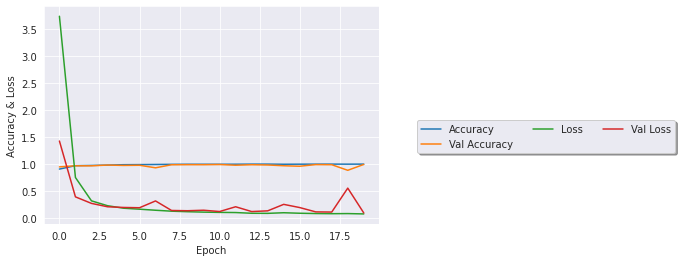

In [ ]:
model_name='ResNet50'
base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=images_size, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

checkpoint_path = model_name + "_training_" + str(epoch_number) + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_images, train_labels, epochs=epoch_number, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)

pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)

print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)

print(cm.diagonal()/cm.sum(axis=1))

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.5,0.5),
          ncol=3, fancybox=True, shadow=True)

model.save(model_name + "_" + str(epoch_number) + ".h5")

# InceptionV3

Epoch 1/20
715/715 [==============================] - ETA: 0s - loss: 4.8646 - accuracy: 0.8448
Epoch 1: saving model to InceptionV3_training_20_epochs/cp.ckpt
715/715 [==============================] - 94s 104ms/step - loss: 4.8646 - accuracy: 0.8448 - val_loss: 5.6232 - val_accuracy: 0.9014
Epoch 2/20
715/715 [==============================] - ETA: 0s - loss: 1.4819 - accuracy: 0.9389
Epoch 2: saving model to InceptionV3_training_20_epochs/cp.ckpt
715/715 [==============================] - 70s 98ms/step - loss: 1.4819 - accuracy: 0.9389 - val_loss: 0.8004 - val_accuracy: 0.9623
Epoch 3/20
715/715 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.9483
Epoch 3: saving model to InceptionV3_training_20_epochs/cp.ckpt
715/715 [==============================] - 73s 102ms/step - loss: 0.5514 - accuracy: 0.9483 - val_loss: 0.5682 - val_accuracy: 0.9086
Epoch 4/20
715/715 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.9670
Epoch 4: saving model t

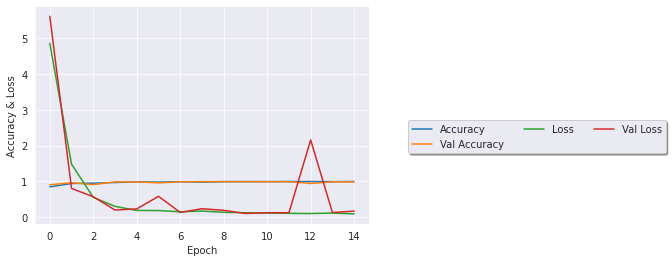

In [ ]:
model_name='InceptionV3'
base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=images_size, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

checkpoint_path = model_name + "_training_" + str(epoch_number) + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_images, train_labels, epochs=epoch_number, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)

pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)

print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)

print(cm.diagonal()/cm.sum(axis=1))

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.5,0.5),
          ncol=3, fancybox=True, shadow=True)

model.save(model_name + "_" + str(epoch_number) + ".h5")

# DenseNet

Epoch 1/20
715/715 [==============================] - ETA: 0s - loss: 2.3281 - accuracy: 0.9105
Epoch 1: saving model to DenseNet121_training_20_epochs/cp.ckpt
715/715 [==============================] - 124s 138ms/step - loss: 2.3281 - accuracy: 0.9105 - val_loss: 0.7213 - val_accuracy: 0.9708
Epoch 2/20
715/715 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.9666
Epoch 2: saving model to DenseNet121_training_20_epochs/cp.ckpt
715/715 [==============================] - 97s 136ms/step - loss: 0.4425 - accuracy: 0.9666 - val_loss: 0.3222 - val_accuracy: 0.9556
Epoch 3/20
715/715 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9759
Epoch 3: saving model to DenseNet121_training_20_epochs/cp.ckpt
715/715 [==============================] - 97s 136ms/step - loss: 0.2354 - accuracy: 0.9759 - val_loss: 0.2603 - val_accuracy: 0.9529
Epoch 4/20
715/715 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9811
Epoch 4: saving model

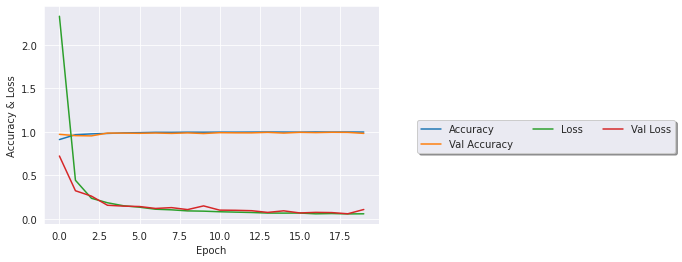

In [ ]:
model_name='DenseNet121'
base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_shape=images_size, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

checkpoint_path = model_name + "_training_" + str(epoch_number) + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_images, train_labels, epochs=epoch_number, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)

pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)

print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)

print(cm.diagonal()/cm.sum(axis=1))

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.5,0.5),
          ncol=3, fancybox=True, shadow=True)

model.save(model_name + "_" + str(epoch_number) + ".h5")

# MobileNetV2

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
715/715 [==============================] - ETA: 0s - loss: 3.5276 - accuracy: 0.8864
Epoch 1: saving model to MobileNetV2_training_20_epochs/cp.ckpt
715/715 [==============================] - 68s 74ms/step - loss: 3.5276 - accuracy: 0.8864 - val_loss: 1.7632 - val_accuracy: 0.6800
Epoch 2/20
714/715 [============================>.] - ETA: 0s - loss: 0.6177 - accuracy: 0.9601
Epoch 2: saving model to MobileNetV2_training_20_epochs/cp.ckpt
715/715 [==============================] - 50s 70ms/step - loss: 0.6176 - accuracy: 0.9601 - val_loss: 0.8017 - val_accuracy: 0.7817
Epoch 3/20
714/715 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.9704
Epoch 3: saving model to MobileNetV2_training_20_epochs/cp.ckpt
715/715 [==============================] - 50s 70ms/step - loss: 0.2891 - accuracy: 0.9704 - val_loss: 0.4560 - val_accuracy: 0.8885
Epoch 4/20
714/715 [============================>.] - ETA:

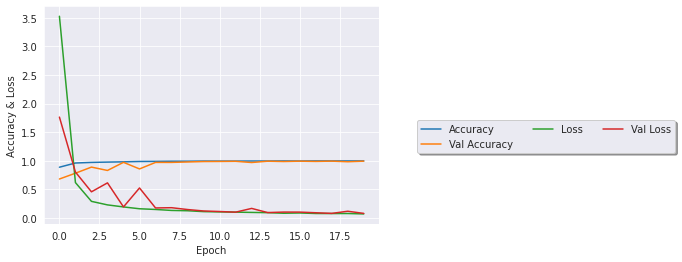

In [ ]:
model_name='MobileNetV2'
base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_shape=images_size, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

checkpoint_path = model_name + "_training_" + str(epoch_number) + "_epochs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_images, train_labels, epochs=epoch_number, validation_data=(val_images, val_labels), callbacks=[stop_early, cp_callback])

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(test_loss, test_accuracy)

pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
testLabels_new = np.argmax(test_labels, axis=1)

print(classification_report(testLabels_new,pred))
cm = confusion_matrix(testLabels_new, pred)
print(cm)

print(cm.diagonal()/cm.sum(axis=1))

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.5,0.5),
          ncol=3, fancybox=True, shadow=True)

model.save(model_name + "_" + str(epoch_number) + ".h5")